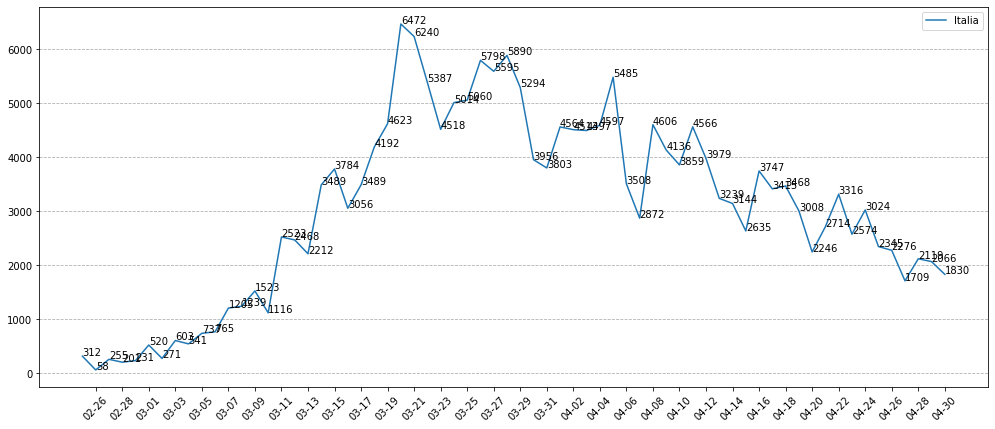

In [73]:
#@title Cresciata giornaliera di contagi sull\'intero territorio Italiano

import requests
import pandas as pd
import random
import numpy as np

rilevazioni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
rilevazioni['data'] = rilevazioni['data'].apply(lambda x : x[5:10])
rilevazioni = rilevazioni.drop(rilevazioni[rilevazioni['denominazione_provincia'] == 'In fase di definizione/aggiornamento'].index)
rilevazioni = rilevazioni.pivot_table(index=['denominazione_regione','denominazione_provincia'], columns='data', values='totale_casi')
rilevazioni.index.names = ['Regione', 'Provincia']

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  step_size = round(len(df.columns) / 30 - 0.5)
  resto = (len(df.columns)-1) % step_size
  ax.set_xticks(ticks=np.arange(resto, len(df.columns) , step=step_size))
  tick_label = list(df.columns)[resto::step_size]
  ax.set_xticklabels(tick_label, rotation=45)
  ax.grid(axis='y', linestyle='--')

  #ax.yaxis.tick_right()
  count = 0
  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    #if count % 2 == 0:
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
    count +=1
  return ax

sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]
crescita = pd.DataFrame(index=sorted_by_infections.index)
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']
_ = plot_annotate(crescita_italia)

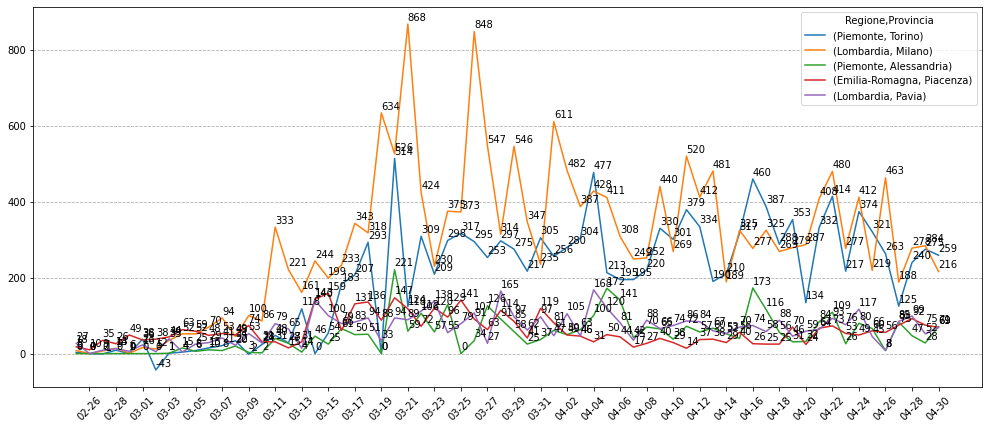

In [74]:
#@title Crescita giornaliere di contagi per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5))
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

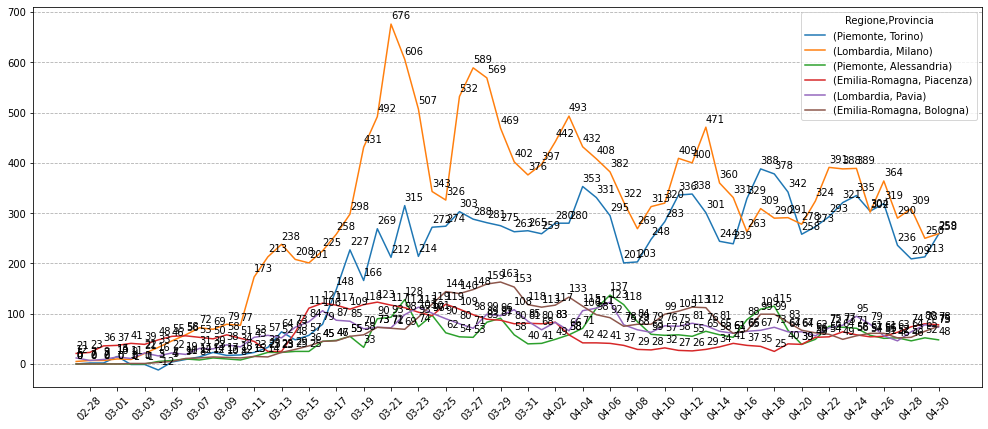

In [75]:
#@title Crescita giornaliera di contagi mediata su un intervallo di 3 giorni per le province con maggior crescita
avg3 = pd.DataFrame(index=crescita.sort_values(by=crescita.columns[-1], ascending=False).index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)
avg3 = avg3.astype('int32')
_ = plot_annotate(avg3.head(6))

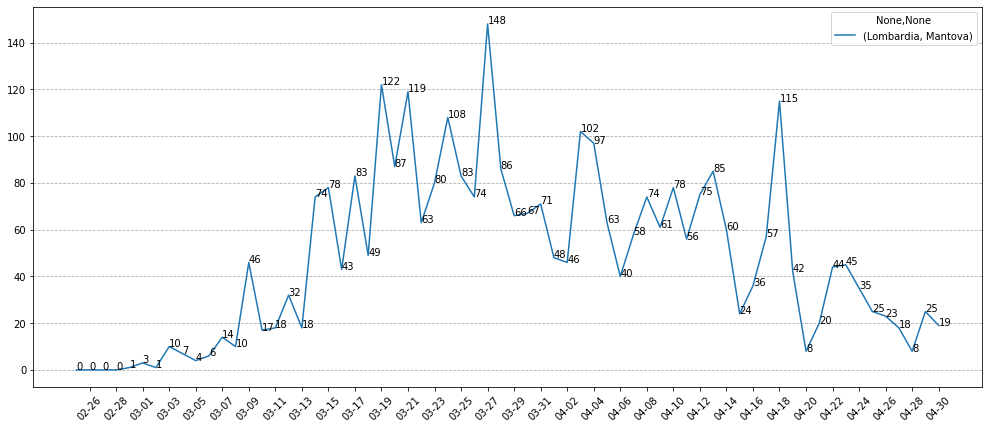

In [76]:
#@title Crescita giornaliera di contagi a Mantova
_ = plot_annotate(crescita.loc[('Lombardia','Mantova')].to_frame().T, ydelta=0)

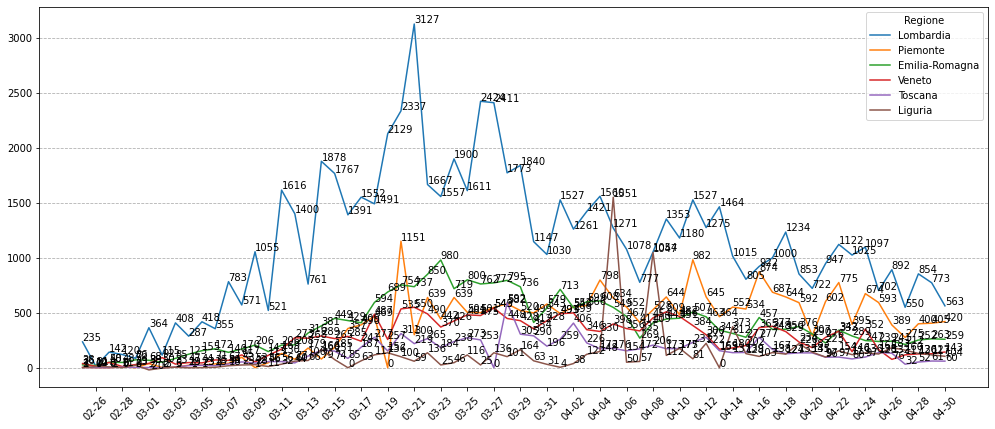

In [77]:
#@title Crescita giornaliera per le 5 regioni maggiormente infette
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))


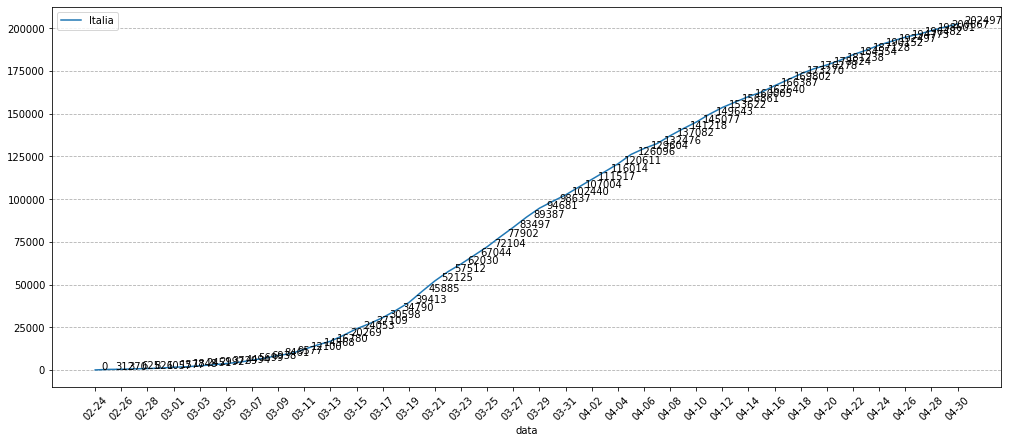

In [78]:
#@title Contagi totali in Italia
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']
_ = plot_annotate(casi_italia, xdelta=0.5)

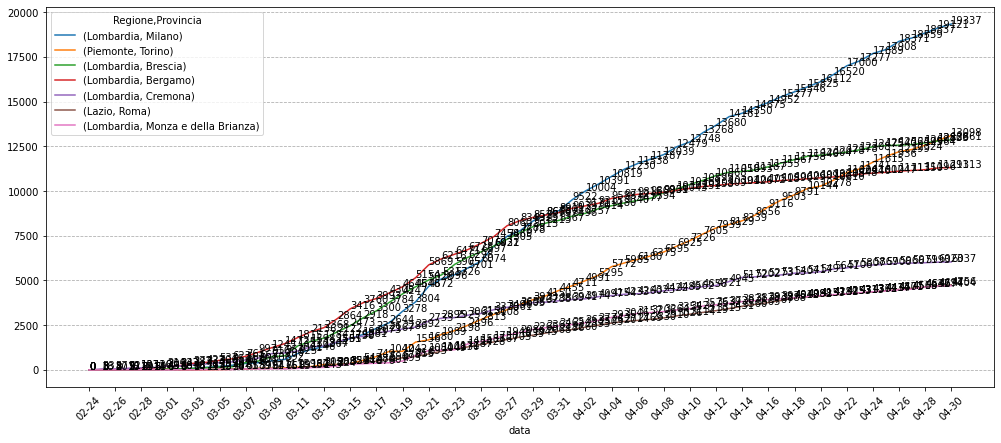

In [79]:
#@title Contagi totali per le province maggiormente infette
_ = plot_annotate(sorted_by_infections.head(7))

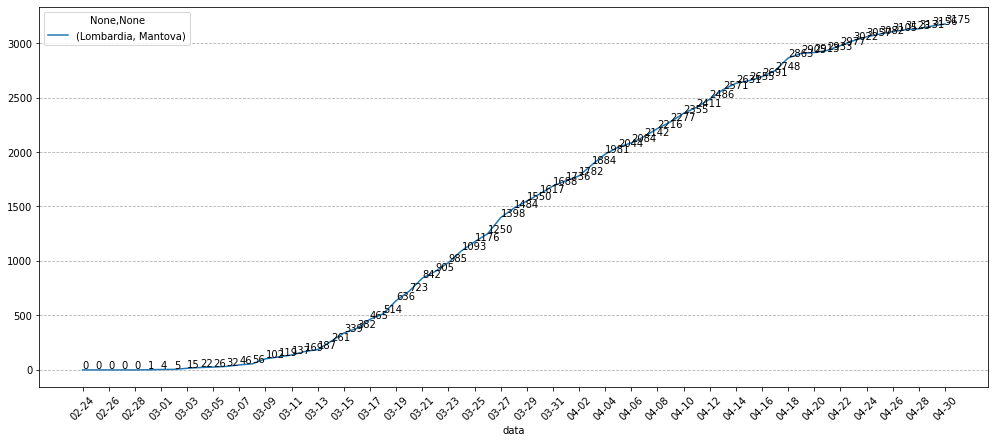

In [80]:
#@title Contagi totali a Mantova
_ = plot_annotate(sorted_by_infections.loc[('Lombardia','Mantova')].to_frame().T)

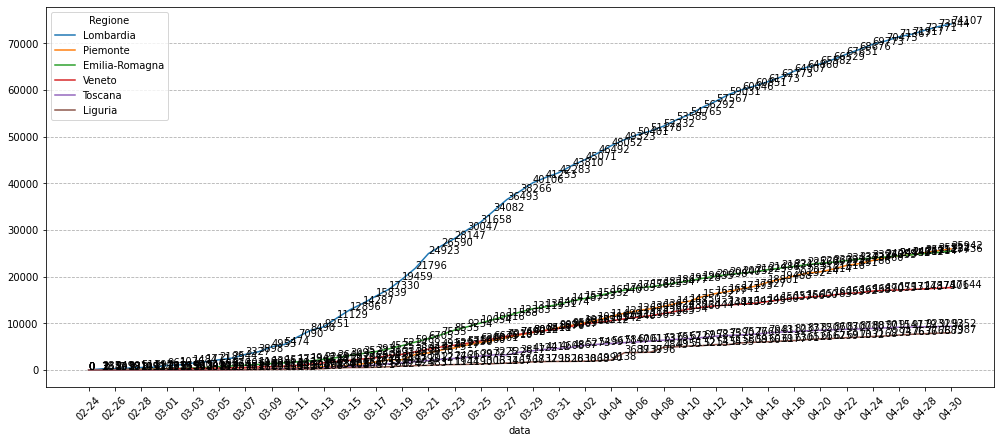

In [81]:
#@title Contagi totali regioni
_ = plot_annotate(regioni.head(6))